In [1]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
    Define the Hodgkin-Huxley class
"""

class Hodgkin_Huxley:
    """
        A class representing the Hodgkin-Huxley model
    """
    def __init__(self, C=1, lrV=-61, KrV=-77, NarV=55, gL=0.3, gK=36, gNa=120,
                 V=-65, I=20, tI=1000):
        """
            Define constants and initial conditions. Defaults are the following:
                C = 1 microF/cm 2
                Leak reversal potential (LrV) = -61 mV
                K reversal potential (KrV) = -77 mV
                Na reversal potential (NarV) = 55 mv
                Leakage conductance (gL) = 0.3 mS/cm^2
                K conductance (gK) = 36 mS/cm^2
                N conductance (gNa) = 120 mS/cm^2
                Initial membrane potential (V) = -65 mV
                Injective Current (I) = 20 uA
                Duration Injective Current (tI) = 1000 us
        """
        
        # assign constants to object parameters
        self.C = C
        self.lrV = lrV
        self.KrV = KrV
        self.NarV = NarV
        self.gL = gL
        self.gK = gK
        self.gNa = gNa
        
        # set initial values
        self.V = V
        alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h = self.rate_constants(-65-self.V)
        self.n = alpha_n/(alpha_n+beta_n)
        self.m = alpha_m/(alpha_m+beta_m)
        self.h = alpha_h/(alpha_h+beta_h)
        
        # set initial injective current
        self.I = I
        self.tI = tI
        
        # create counter for steps
        self.counter = 0
        
        # create lists for storing values
        self.n_vals = []
        self.m_vals = []
        self.h_vals = []
        self.Na_conduct = []
        self.K_conduct = []
        self.Cap_I = []
        self.leak_I = []
        self.Na_I = []
        self.K_I = []
        self.V_vals = []
        
    @staticmethod
    def rate_constants(V):
        """
            Calculates all rate constants for given membrane potential
            
            input: membrane potential (V)
            output: (alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h)
        """
        # calculate alpha_n
        alpha_n = 0.01*(V+10)/(np.exp((V+10)/10)-1)
        # calculate beta_n
        beta_n = 0.125*np.exp(V/80)
        # calculate alpha_m
        alpha_m = 0.1*(V+25)/(np.exp((V+25)/10)-1)
        # calculate beta_m
        beta_m = 4*np.exp(V/18)
        # calculate alpha_h
        alpha_h = 0.07*np.exp(V/20)
        # calculate beta_h
        beta_h = 1/(np.exp((V+30)/10)+1)
        
        # return rate constants
        return (alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h)
    
    def derivative(self, alpha, beta, c):
        """
            Calculates derivative term
            
            inputs:
                rate constant 1 (alpha)
                rate constant 2 (beta)
                activation/inactivation value (c)
            outputs:
                derivative of c
        """
        
        # return derivative of c
        return alpha*(1-c) - beta*c
        
    def current(self, coefficient, V1, V2):
        """
            Calculates current term
            
            inputs:
                coefficient (set to whatever is multiplied by potential difference)
                V1 (1st potential)
                V2 (2nd potential)
            outputs
                current (I)
            
        """
        # return the current
        return coefficient*(V1-V2)
    
    def step(self, time_step=0.001):
        """
            Does one step of Hodgkin-Huxley model
            
            input: time_step (length of time for one iteration of model)
        """
        # turn off injective current if greater than step
        if self.counter > self.tI:
            self.I = 0
        self.counter += 1 # increment counter
        
        # calculate currents
        leak_I = self.current(self.gL, self.V, self.lrV)
        K_I = self.current(self.gK*(self.n**4), self.V, self.KrV)
        Na_I = self.current(self.gNa*(self.m**3)*self.h, self.V, self.NarV)
        
        # Calculate new voltage
        pastV = self.V # record current voltage
        self.V = self.V + time_step*(1/self.C)*(self.I - (leak_I + K_I + Na_I))

        # calculate rate constants using current membrane potential
        alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h = self.rate_constants(-65-self.V)
        
        # Use Eulers method to get new activation values
        self.n = self.derivative(alpha_n, beta_n, self.n)*time_step + self.n
        self.m = self.derivative(alpha_m, beta_m, self.m)*time_step + self.m
        self.h = self.derivative(alpha_h, beta_h, self.h)*time_step + self.h
        
        # add values to lists
        self.n_vals.append(self.n)
        self.m_vals.append(self.m)
        self.h_vals.append(self.h)
        self.Na_conduct.append(self.gNa*(self.m**3)*self.h)
        self.K_conduct.append(self.gK*(self.n**4))
        self.Cap_I.append(self.C*(self.V-pastV)/time_step)
        self.leak_I.append(leak_I)
        self.Na_I.append(Na_I)
        self.K_I.append(K_I)
        self.V_vals.append(self.V)

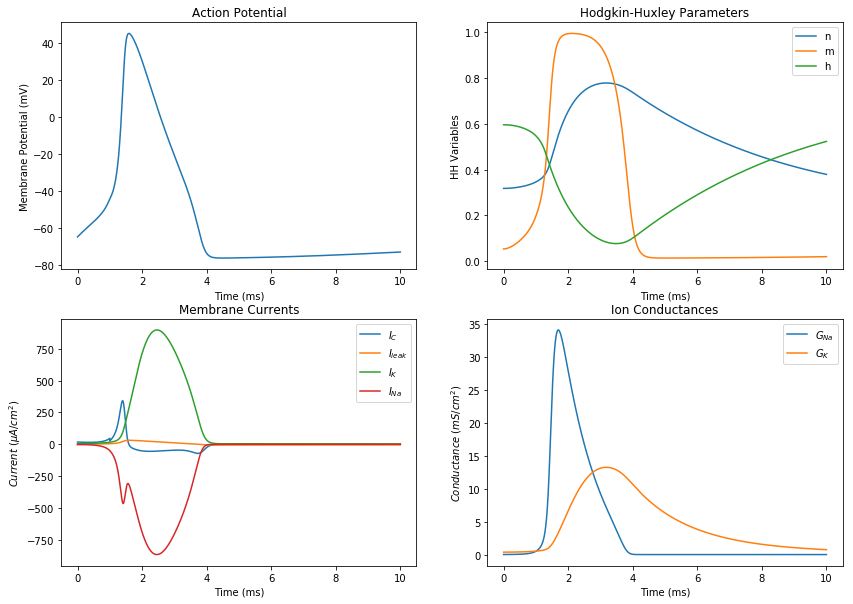

In [3]:
# Create function to run model
def run_model(hhmodel, iterations=10000):
    # Run for 10,000 steps
    for i in range(iterations):
        hhmodel.step()

    # Create Figure
    plt.figure(figsize=(14,10))

    # Create time array
    time = np.linspace(0,10-0.001,iterations)

    # Plot Voltage
    plt.subplot(221)
    plt.plot(time, hhmodel.V_vals)
    plt.title('Action Potential')
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')

    # Plot n,m, and h
    plt.subplot(222)
    plt.plot(time, hhmodel.n_vals, label='n')
    plt.plot(time, hhmodel.m_vals, label='m')
    plt.plot(time, hhmodel.h_vals, label='h')
    plt.legend()
    plt.title('Hodgkin-Huxley Parameters')
    plt.xlabel('Time (ms)')
    plt.ylabel('HH Variables')

    # Plot Currents
    plt.subplot(223)
    plt.plot(time, hhmodel.Cap_I, label=r'$I_{C}$')
    plt.plot(time, hhmodel.leak_I, label=r'$I_{leak}$')
    plt.plot(time, hhmodel.K_I, label=r'$I_{K}$')
    plt.plot(time, hhmodel.Na_I, label=r'$I_{Na}$')
    plt.legend()
    plt.title('Membrane Currents')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$Current\ (\mu A/cm^{2})$')

    # Plot Conductances
    plt.subplot(224)
    plt.plot(time, hhmodel.Na_conduct, label=r'$G_{Na}$')
    plt.plot(time, hhmodel.K_conduct, label=r'$G_{K}$')
    plt.legend()
    plt.title('Ion Conductances')
    plt.xlabel('Time (ms)')
    plt.ylabel(r'$Conductance\ (mS/cm^{2})$')

    # Show figures
    plt.show()
    
# Create Hodgkin Huxley model with default parameters
hhmodel = Hodgkin_Huxley()
run_model(hhmodel)

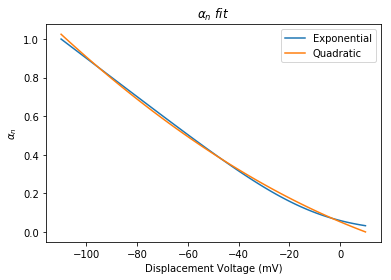

In [4]:
"""
    Fit quadratic to alpha_n and V
"""

# define alpha_n
def alpha_n(V): return 0.01*(V+10)/(np.exp((V+10)/10)-1)

# plot alpha_n at a range of V's
V_range = np.linspace(-110,10,100)
alpha_n_range = alpha_n(V_range)

# fit quadratic
p_coeff = np.polyfit(V_range,alpha_n_range,2)
alpha_n_qfit = p_coeff[0]*V_range**2 + p_coeff[1]*V_range + p_coeff[2]

# plot fit
plt.figure()
plt.plot(V_range, alpha_n_range, label='Exponential')
plt.plot(V_range, alpha_n_qfit, label='Quadratic')
plt.legend()
plt.title(r'$\alpha_{n}\ fit$')
plt.ylabel(r'$\alpha_{n}$')
plt.xlabel('Displacement Voltage (mV)')
plt.show()

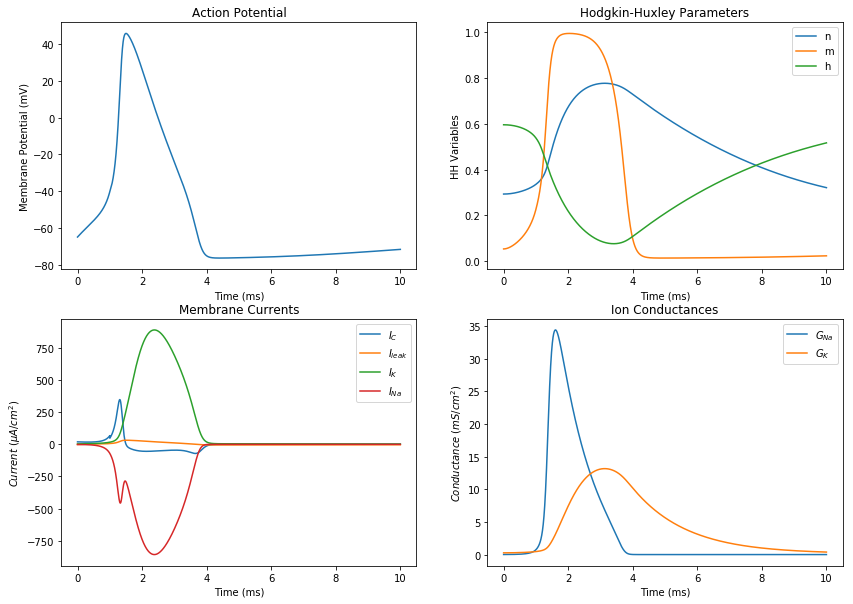

In [5]:
"""
    Re-run Hodgkin-Huxley model with quadratic alpha_n fit
"""
@staticmethod
def mod_rate_constants(V):
        """
            Calculates all rate constants for given membrane potential
            NOTE: This is updated with the quadratic fit for alpha_n
            
            input: membrane potential (V)
            output: (alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h)
        """
        # calculate alpha_n
        alpha_n = p_coeff[0]*V**2 + p_coeff[1]*V + p_coeff[2]
        # calculate beta_n
        beta_n = 0.125*np.exp(V/80)
        # calculate alpha_m
        alpha_m = 0.1*(V+25)/(np.exp((V+25)/10)-1)
        # calculate beta_m
        beta_m = 4*np.exp(V/18)
        # calculate alpha_h
        alpha_h = 0.07*np.exp(V/20)
        # calculate beta_h
        beta_h = 1/(np.exp((V+30)/10)+1)
        
        # return rate constants
        return (alpha_n, beta_n, alpha_m, beta_m, alpha_h, beta_h)
    
# Create a modified Hodgkin Huxley class
Mod_Hodgkin_Huxley = Hodgkin_Huxley

# Replace the rate_constants method with the modified one
Mod_Hodgkin_Huxley.rate_constants = mod_rate_constants

# Create a modified Hodgkin Huxley model
hhmodel_mod = Mod_Hodgkin_Huxley()

# Run model
run_model(hhmodel_mod)

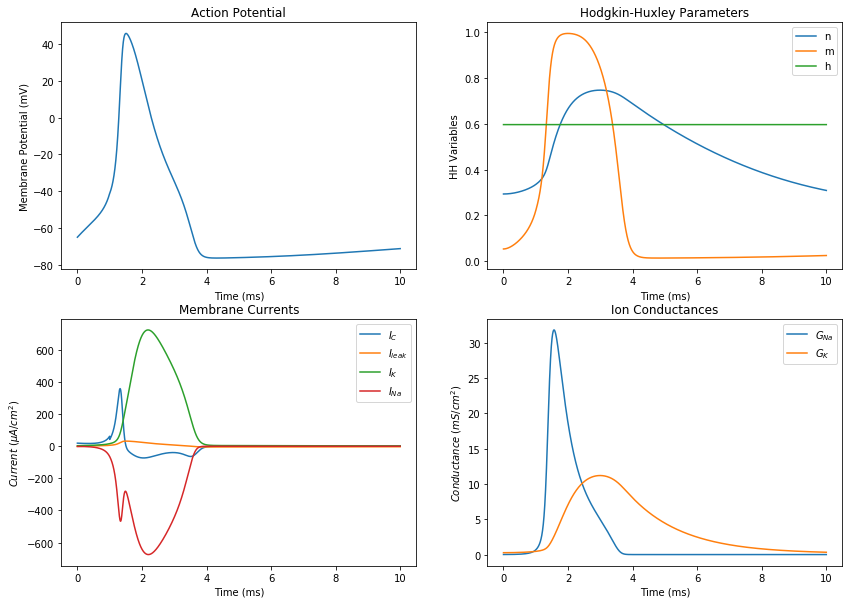

In [6]:
"""
    Implement Reduced HH model
"""
def mod_step(self, time_step=0.001):
        """
            Does one step of Hodgkin-Huxley model
            NOTE: modified step method to implement Instantaneous I_Na
            
            input: time_step (length of time for one iteration of model)
        """
        # turn off injective current if greater than step
        if self.counter > self.tI:
            self.I = 0
        self.counter += 1 # increment counter
        
        # calculate currents
        leak_I = self.current(self.gL, self.V, self.lrV)
        K_I = self.current(self.gK*(self.n**4), self.V, self.KrV)
        Na_I = self.current(self.gNa*(self.m**3)*(0.89-1.1*self.n), self.V, self.NarV)
        
        # Calculate new voltage
        pastV = self.V # record current voltage
        self.V = self.V + time_step*(1/self.C)*(self.I - (leak_I + K_I + Na_I))

        # calculate rate constants using current membrane potential
        alpha_n, beta_n, alpha_m, beta_m, _, _ = self.rate_constants(-65-self.V)
        
        # Use Eulers method to get new activation values (m and h are constant here)
        self.n = self.derivative(alpha_n, beta_n, self.n)*time_step + self.n
        self.m = self.derivative(alpha_m, beta_m, self.m)*time_step + self.m
           
        # add values to lists
        self.n_vals.append(self.n)
        self.m_vals.append(self.m)
        self.h_vals.append(self.h)
        self.Na_conduct.append(self.gNa*(self.m**3)*(0.89-1.1*self.n))
        self.K_conduct.append(self.gK*(self.n**4))
        self.Cap_I.append(self.C*(self.V-pastV)/time_step)
        self.leak_I.append(leak_I)
        self.Na_I.append(Na_I)
        self.K_I.append(K_I)
        self.V_vals.append(self.V)

# Create a modified Hodgkin Huxley class
Mod_Hodgkin_Huxley_2 = Hodgkin_Huxley

# Replace the step method with the modified one
Mod_Hodgkin_Huxley_2.step = mod_step

# Create a modified Hodgkin Huxley model
hhmodel_mod2 = Mod_Hodgkin_Huxley_2()

# Run model
run_model(hhmodel_mod2)